In [33]:
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
import json, os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
load_dotenv()

True

In [71]:
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
llm = ChatOpenAI(
    api_key = os.getenv("OPENROUTER_API_KEY"),
    base_url = "https://openrouter.ai/api/v1",
    model = "google/gemini-2.5-flash",
    max_completion_tokens=200
)

In [ ]:
import requests
from langchain_core.tools import tool
from typing import Optional
import os, requests

@tool
def menu_tool(
    search: Optional[str] = None,
    type: Optional[str] = None,
    price_min: Optional[float] = None,
    price_max: Optional[float] = None,
) -> dict:
    """
    Retrieves restaurant menu items based on the provided criteria.

    Args:
        search (str | None): Dish name or keyword to search for.
        type (str | None): "veg" or "nonveg" to filter dish type.
        price_min (float | None): Minimum price filter.
        price_max (float | None): Maximum price filter.

    Returns:
        dict: Dictionary containing matching menu items
    """
    base_url = os.getenv("BASE_URL")
    params = {
        "search": search,
        "type": type,
        "price_min": price_min,
        "price_max": price_max
    }

    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling backend: {e}")
        return {"error": str(e)}


@tool
def kb_tool(query:str) -> str:
    """
    Retrieves restaurant knowledge base information based on a user query.

    Args:
        query (str): Question or topic related to restaurant policies, FAQs, or general info.

    Returns:
        str: Retreived info
    """
    return "Lumina Bistro is a restaurant located at Jhamsikhel, Lalitpur."

In [72]:
tools = [menu_tool, kb_tool]

llm_with_tools = llm.bind_tools(tools)

tools_node = ToolNode(tools=tools)

In [49]:
print(menu_tool({"search":"spicy"}))


[{'category_id': 5, 'subcategory': 'Non-Veg', 'name': 'Spicy Honey Wings', 'description': 'Crispy chicken wings tossed in a sweet and spicy honey sauce.', 'is_available': True, 'id': 34, 'variations': [{'item_id': 34, 'label': 'Default', 'final_price': '350.00', 'is_available': True, 'id': 49}]}, {'category_id': 6, 'subcategory': 'Non-Veg', 'name': 'Spicy Buff & Jalapeño Pizza', 'description': 'marinated buff, jalapeños, olives, spicy chick-tomato sauce', 'is_available': True, 'id': 38, 'variations': [{'item_id': 38, 'label': 'Default', 'final_price': '580.00', 'is_available': True, 'id': 53}]}, {'category_id': 1, 'subcategory': 'Veg', 'name': 'Mustang Aloo', 'description': 'A spicy and tangy potato dish from the Mustang region of Nepal.', 'is_available': True, 'id': 13, 'variations': [{'item_id': 13, 'label': 'Default', 'final_price': '320.00', 'is_available': True, 'id': 13}]}, {'category_id': 1, 'subcategory': 'Non-Veg', 'name': 'Chicken Chilly', 'description': 'A spicy and savory d

In [37]:
from typing import TypedDict, Annotated, List, Optional, Any, Dict, Literal
from langgraph.graph.message import add_messages
from langchain.schema import BaseMessage

# Define a single task
# class TaskDict(TypedDict):
#     intent: Literal["menu", "knowledge_base", "chitchat", "human_escalation", "ambiguous"]
#     confidence: float
#     slots: Dict[str, Any]
#     status: Literal["awaiting_slots", "pending_call", "done"]
#     result: Optional[Any]

# Define the overall state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]  # chat history
    # tasks: List[TaskDict]                          

In [38]:
SYSTEM_PROMPT = """SYSTEM:
You are a restaurant assistant agent. You have access to the following tools:

1. menu_tool
   Description: Returns menu items based on the following input parameters.
   Inputs:
     - search (string | null): Dish or keyword to search
     - type (string | "veg"/"nonveg"/null): Dish type
     - price_min (number | null): Minimum price
     - price_max (number | null): Maximum price
   Output: JSON object with matching menu items

2. kb_tool
   Description: Answers general knowledge questions about the restaurant.
   Inputs:
     - query (string): The question or topic
   Output: JSON object containing the answer

Your responsibilities:
- Read the user's message and your current memory (tasks + entities + messages)
- Decide which tool(s), if any, need to be called. Only call a tool if the required info is missing or outdated.
- Extract all required inputs for the tools from the user query and memory.
- Update the state: tasks, entities, and messages.
- Generate a concise response to the user using available tool results or memory.
- If slots are missing, ask the user for clarification instead of calling the tool.

Instructions for output:
Respond with a JSON object with the following keys:

{
  "tool_calls": [
    {
      "tool_name": "menu_tool" | "kb_tool",
      "inputs": { ... }  # filled input parameters
    }
  ],
  "answer": "string",         # final assistant message
  "updated_memory": {         # updated state to store
    "tasks": [...],
    "entities": {...}
  }
}

Rules:
- Do not hallucinate: only use memory or tool results.
- Reuse previous results if the same task with same slots is already done.
- If the user's request cannot be answered with existing memory and tool info, politely ask for clarification.
- Be concise (1-3 sentences) in your answers.

USER MESSAGE:
{last_user_message}

CURRENT MEMORY:
Tasks: {tasks}
Entities: {entities}
Messages: {messages}
"""

In [73]:
def restaurant_agent(state: State) -> State:

    # Build system prompt
    SYSTEM_PROMPT = f"""
SYSTEM:
You are a restaurant assistant.
You have the following tools available:

menu_tool(query: str)
kb_tool(query: str)

Instructions:
- Read the user's message.
- If a tool is needed, respond ONLY with a JSON object in this format:
{{"tool_calls":[{{"name":"<tool_name>","arguments":{{...}}}}]}}
- Do NOT include any extra text outside this JSON.
- If no tool is needed, respond with: "no_tool_call"

CHAT HISTORY:
{state["messages"]}
"""


    # Call LLM
    llm_response = llm_with_tools.invoke([SYSTEM_PROMPT])
    agent_reply = llm_response.content  # simple string response

    # Optional: if LLM instructed a tool call, do it here
    # For now, we can skip structured tool calls and just return the reply

    # Add agent reply to messages
    state["messages"].append({"role": "assistant", "content": agent_reply})

    return state


In [74]:
from typing import Literal
from pydantic import BaseModel
# from langchain.schema import SystemMessage

reviewer_llm = llm 
class ReviewDecision(BaseModel):
    decision: Literal["ok", "needs_more"]
    rationale: str = ""
    answer: str = ""
    todo: str = ""

REVIEWER_PROMPT = """You are a reviewer.
Compare the user's request with the latest tool outputs in the conversation.
Return a JSON object with fields:
- decision: "ok" | "needs_more"
- rationale: brief reason
- answer: final user-facing answer if decision == "ok", else ""
- todo: what is still needed if decision == "needs_more"
"""
# Wrap the model to return the Pydantic object directly:
structured_reviewer = reviewer_llm.with_structured_output(ReviewDecision)

def reviewer_node(state: State):
    from langchain.schema import SystemMessage
    msgs = [SystemMessage(content=REVIEWER_PROMPT)] + state["messages"]
    review: ReviewDecision = structured_reviewer.invoke(msgs)
    updates = {}

    if review.decision == "ok" and review.answer:
        # append final answer into the transcript
        from langchain.schema import AIMessage
        updates["messages"] = [AIMessage(content=review.answer)]
    else:
        from langchain.schema import SystemMessage
        updates["messages"] = [SystemMessage(content=f"Reviewer: needs more info → {review.todo}")]

    # If you also have `review_decision` in your State, set it:
    updates["review_decision"] = review.decision  # harmless if not in State
    return updates


In [75]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition


def route_after_reviewer(state: State):
    return "intent_node" if state.get("review_decision") == "needs_more" else "__end__"

def build_graph():
    g = StateGraph(State)

    g.add_node("intent_node", restaurant_agent)
    g.add_node("tools", tools_node)          # or tools_node.invoke
    g.add_node("reviewer", reviewer_node)

    g.add_edge(START, "intent_node")

    # If assistant asked for tools, go to tools; otherwise go to reviewer
    g.add_conditional_edges(
        "intent_node",
        tools_condition,
        {"tools": "tools", "__end__": "reviewer"},
    )

    # After tools run, go to reviewer (no loop yet)
    g.add_edge("tools", "reviewer")

    # Reviewer decides whether to loop back or end
    g.add_conditional_edges(
        "reviewer",
        route_after_reviewer,
        {"intent_node": "intent_node", "__end__": END},
    )

    return g.compile()


In [76]:
graph = build_graph()

In [79]:
from langchain.schema import HumanMessage

state = {
    "messages": [HumanMessage(content="chicken spicy")]
}
result = graph.invoke(state)

In [80]:
result

{'messages': [HumanMessage(content='chicken spicy', additional_kwargs={}, response_metadata={}, id='bcb3d0c3-e625-494f-a844-a2f80b490052'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='f071ce07-d07c-4423-89a6-649e2c5f0d88'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='91bb95cf-0544-49c2-ae33-a5c6d11e9369'),
  SystemMessage(content="Reviewer: needs more info → Please specify what you're looking for regarding 'chicken spicy.'", additional_kwargs={}, response_metadata={}, id='d5c6ffbf-525f-4127-8b17-793ae31d0896')]}

In [63]:
last_msg = state["messages"][-1]
print("content:", getattr(last_msg, "content", None))
print("additional_kwargs:", getattr(last_msg, "additional_kwargs", None))


content: do you have anything spicy
additional_kwargs: {}


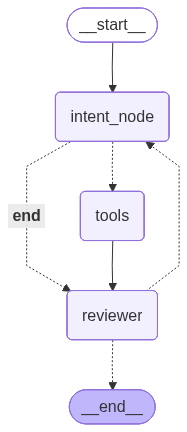

In [16]:
build_graph()